In [1]:
import cv2
cv2.__version__

'4.8.1'

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from ultralytics import YOLO

In [37]:
# Кол-во файлов в папке
files = os.listdir('img/Cam1/')
len(files)

1584

In [4]:
# Загружаем нужную модель нейронной сети
model = YOLO('./models/yolov8n.pt')
# model = YOLO('./models/yolov8s.pt')
# model = YOLO('./models/yolov8m.pt')
# model = YOLO('./models/yolov8l.pt')
# model = YOLO('./models/yolov8x.pt')

100%|██████████| 6.23M/6.23M [00:53<00:00, 123kB/s] 


### Проблема 1. Ошибки распознавания

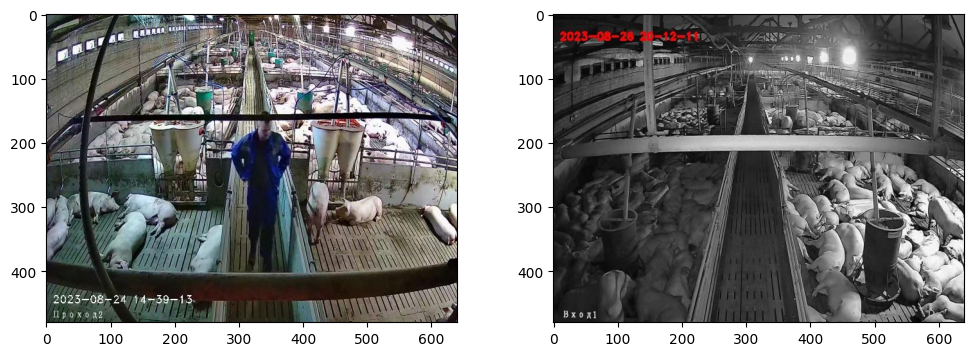

In [26]:
img1 = cv2.imread("img/2023-08-24 14-39-13.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("img/2023-08-26 20-12-11.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(img1);
ax[1].imshow(img2);


0: 480x640 1 person, 96.2ms
Speed: 2.1ms preprocess, 96.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 66.1ms
Speed: 1.0ms preprocess, 66.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


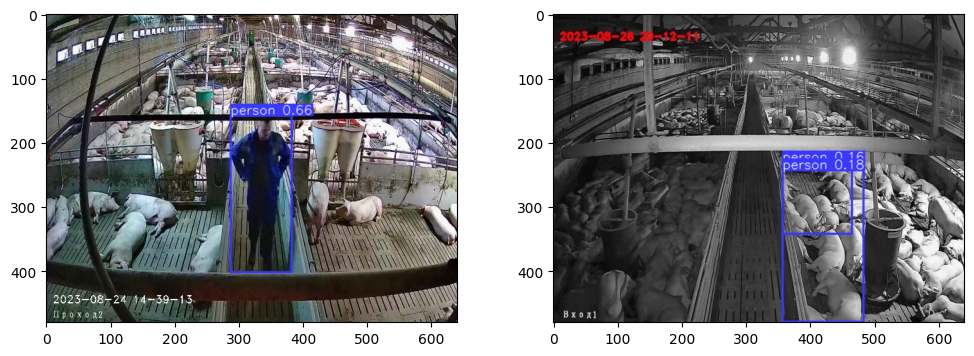

In [30]:
res1 = model.predict(img1, conf=0.15, classes=0)
res2 = model.predict(img2, conf=0.15, classes=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(res1[0].plot(labels=True));
ax[1].imshow(res2[0].plot(labels=True));

### Проблема 2. Низкая производительность

### Выравнивание гистограммы

https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

https://docs.opencv.org/4.x/d4/d1b/tutorial_histogram_equalization.html

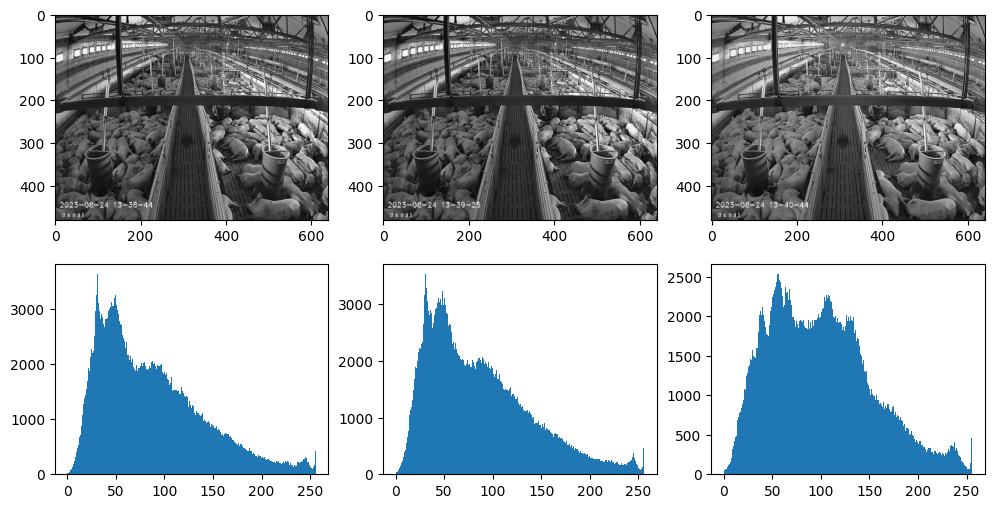

In [34]:
img1 = cv2.imread("img/Cam1/" + files[0], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("img/Cam1/" + files[1], cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("img/Cam1/" + files[2], cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0, 0].imshow(img1, cmap='gray');
ax[0, 1].imshow(img2, cmap='gray');
ax[0, 2].imshow(img3, cmap='gray');

ax[1, 0].hist(img1.ravel(), 256, [0,256]);
ax[1, 1].hist(img2.ravel(), 256, [0,256]);
ax[1, 2].hist(img3.ravel(), 256, [0,256]);

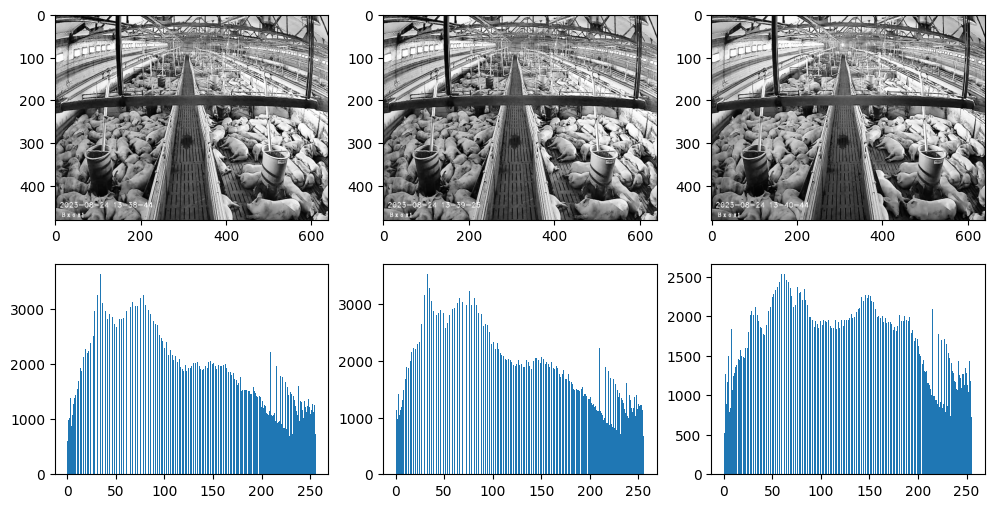

In [35]:
img1 = cv2.imread("img/Cam1/" + files[0], cv2.IMREAD_GRAYSCALE)
img1 = cv2.equalizeHist(img1)

img2 = cv2.imread("img/Cam1/" + files[1], cv2.IMREAD_GRAYSCALE)
img2 = cv2.equalizeHist(img2)

img3 = cv2.imread("img/Cam1/" + files[2], cv2.IMREAD_GRAYSCALE)
img3 = cv2.equalizeHist(img3)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0, 0].imshow(img1, cmap='gray');
ax[0, 1].imshow(img2, cmap='gray');
ax[0, 2].imshow(img3, cmap='gray');

ax[1, 0].hist(img1.ravel(), 256, [0,256]);
ax[1, 1].hist(img2.ravel(), 256, [0,256]);
ax[1, 2].hist(img3.ravel(), 256, [0,256]);

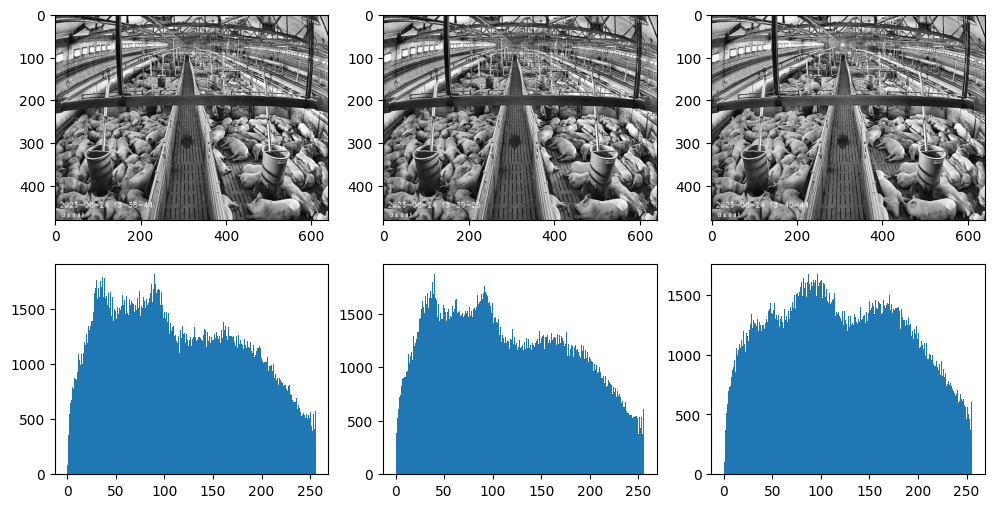

In [36]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

img1 = cv2.imread("img/Cam1/" + files[0], cv2.IMREAD_GRAYSCALE)
img1 = clahe.apply(img1)

img2 = cv2.imread("img/Cam1/" + files[1], cv2.IMREAD_GRAYSCALE)
img2 = clahe.apply(img2)

img3 = cv2.imread("img/Cam1/" + files[2], cv2.IMREAD_GRAYSCALE)
img3 = clahe.apply(img3)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0, 0].imshow(img1, cmap='gray');
ax[0, 1].imshow(img2, cmap='gray');
ax[0, 2].imshow(img3, cmap='gray');

ax[1, 0].hist(img1.ravel(), 256, [0,256]);
ax[1, 1].hist(img2.ravel(), 256, [0,256]);
ax[1, 2].hist(img3.ravel(), 256, [0,256]);

### Детекция движения по порогу

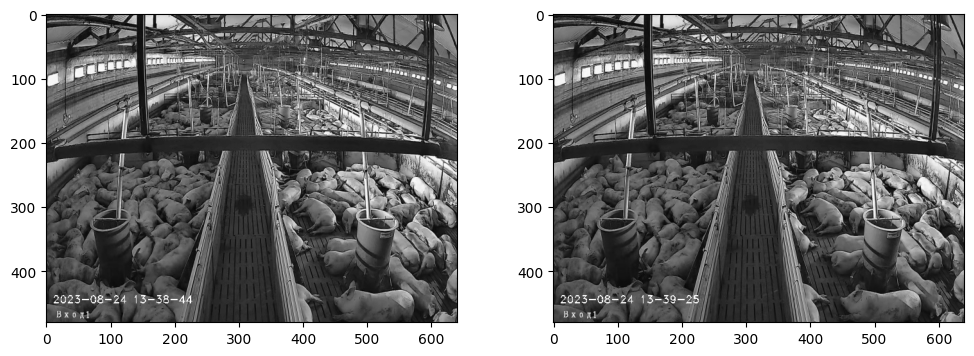

In [86]:
# Берем два соседних кадра
img1 = cv2.imread("img/Cam1/" + files[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread("img/Cam1/" + files[1])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(img1, cmap='gray');
ax[1].imshow(img2, cmap='gray');

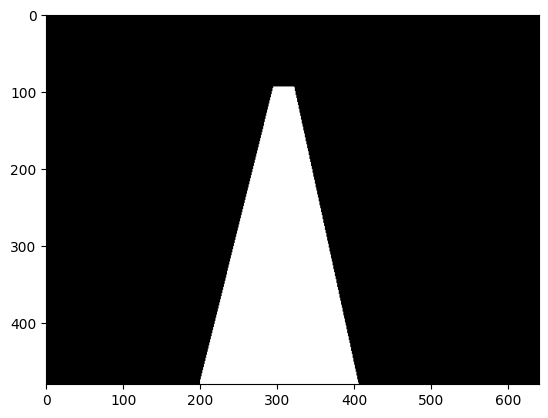

In [87]:
# Загружаем маску
mask = cv2.imread("img/mask_cam1_1_yolo.jpg")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)[1]
plt.imshow(mask, cmap='gray');

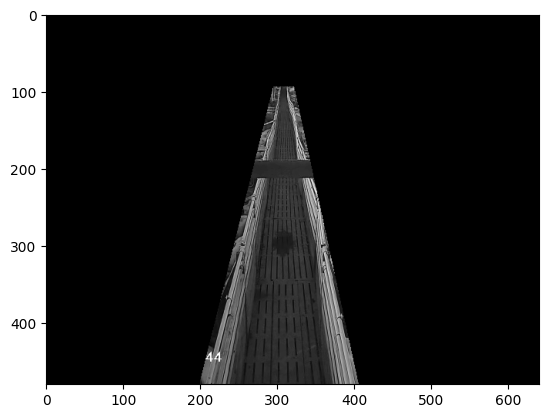

In [88]:
# Накладываем маску на изображения
img1 = cv2.bitwise_and(img1, img1, mask = mask)
img2 = cv2.bitwise_and(img2, img2, mask = mask)

plt.imshow(img1, cmap='gray');

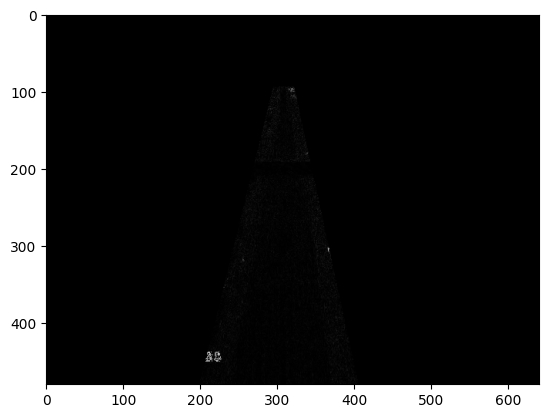

In [89]:
# Смотрим разницу кадров. Почти все пиксели черные, значит движения не было 
diff = cv2.absdiff(img1, img2)
plt.imshow(diff, cmap='gray');

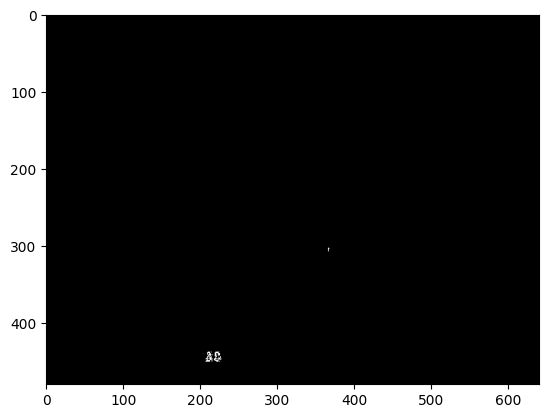

In [90]:
# Бинаризация изображения
threshold = cv2.threshold(diff, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(threshold, cmap='gray');

In [91]:
# кол-во разных пикселей на изображениях, где НЕТ изменения
diff = cv2.absdiff(img1, img2)
threshold = cv2.threshold(diff, 100, 255, cv2.THRESH_BINARY)[1]
threshold.sum() / 255

128.0

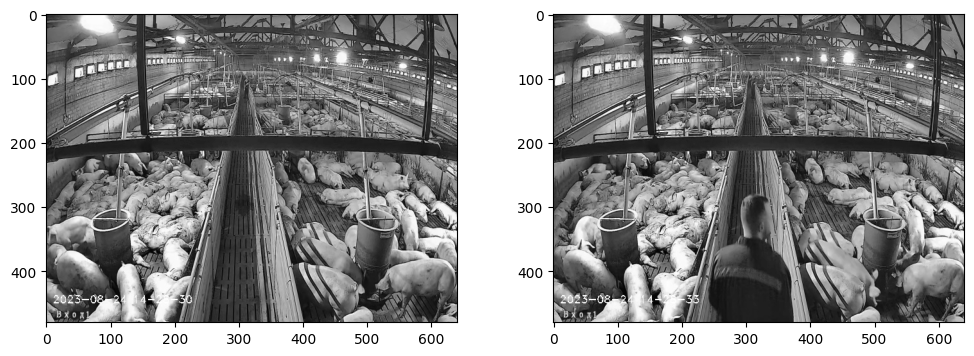

In [69]:
# Теперь посмотрим как будет выглядеть разница кадров, где есть движение
img1 = cv2.imread("img/Cam1/" + files[456])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread("img/Cam1/" + files[457])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(img1, cmap='gray');
ax[1].imshow(img2, cmap='gray');

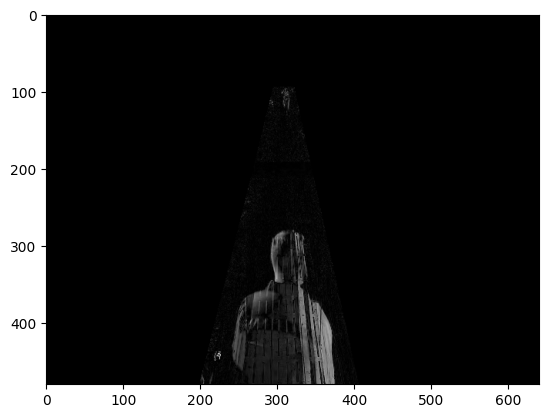

In [70]:
# Накладываем маску на изображения
img1 = cv2.bitwise_and(img1, img1, mask = mask)
img2 = cv2.bitwise_and(img2, img2, mask = mask)

# Смотрим разницу кадров.
diff = cv2.absdiff(img1, img2)
plt.imshow(diff, cmap='gray');

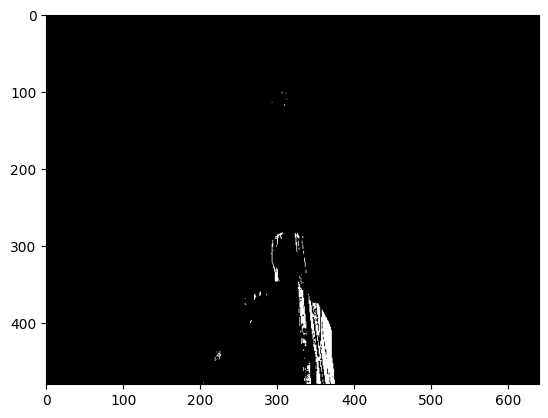

In [84]:
# Бинаризация изображения
threshold = cv2.threshold(diff, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(threshold, cmap='gray');

In [81]:
# кол-во разных пикселей на изображениях, где ЕСТЬ изменения
diff = cv2.absdiff(img1, img2)
threshold = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)[1]
threshold.sum() / 255

5867.0

Теперь надо определить порог по котому будем считать, что есть движение

In [58]:
diff2 = []
for i in tqdm(range(1, len(files))):
  img1 = cv2.imread("img/Cam1/"+files[i-1])
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2 = cv2.imread("img/Cam1/"+files[i])
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  
  img1 = cv2.bitwise_and(img1, img1, mask = mask)
  img2 = cv2.bitwise_and(img2, img2, mask = mask)
  
  absdiff = cv2.absdiff(img1, img2)
  threshold = cv2.threshold(absdiff, 100, 255, cv2.THRESH_BINARY)[1]
  diff2.append(threshold.sum() / 255)

100%|██████████| 1583/1583 [00:21<00:00, 73.81it/s]


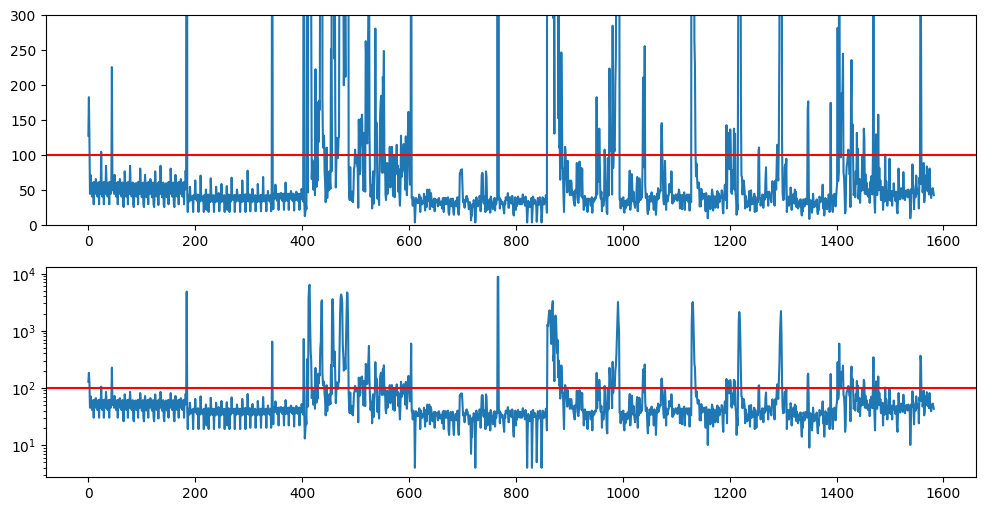

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(diff2)
ax[0].set_ylim(0, 300)
ax[0].axhline(100, color='r')

ax[1].plot(diff2)
ax[1].set_yscale('log')
ax[1].axhline(100, color='r')

### Решение проблемы 1


0: 480x640 1 person, 119.8ms
Speed: 5.3ms preprocess, 119.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 91.3ms
Speed: 1.0ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


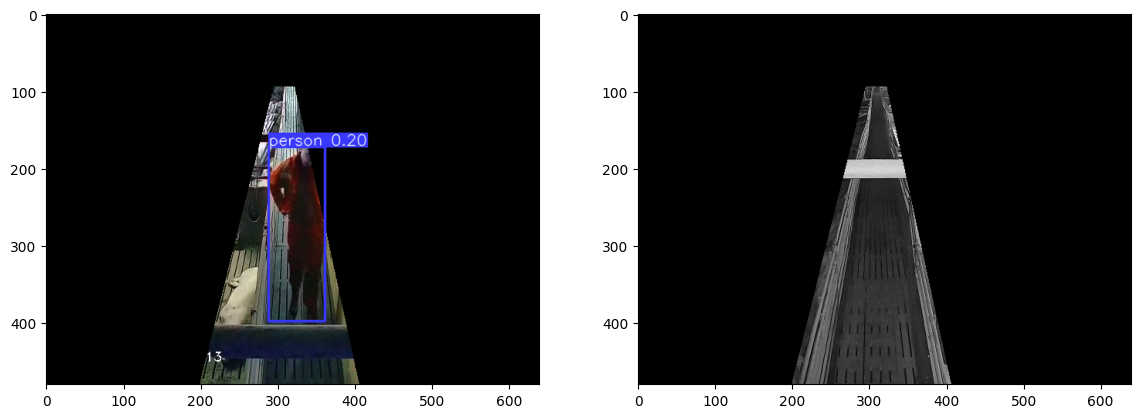

In [96]:
conf=0.15

img1 = cv2.imread("img/2023-08-24 14-39-13.jpg")
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1m = cv2.bitwise_and(img1, img1, mask = mask)
res1 = model.predict(img1m, conf=conf, classes=0)

img2 = cv2.imread("img/2023-08-26 20-12-11.jpg")
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2m = cv2.bitwise_and(img2, img2, mask = mask)
res2 = model.predict(img2m, conf=conf, classes=0)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(res1[0].plot(labels=True));
ax[1].imshow(res2[0].plot(labels=True));


In [97]:
# Функция отрисовки рамки вокруг найденого человека на исходном изображении
def plot_rectangle(img, res):
    img1 = img
    (x1, y1) = (int(res[0].boxes.xyxy[0][0]), int(res[0].boxes.xyxy[0][1]))
    (x2, y2) = (int(res[0].boxes.xyxy[0][2]), int(res[0].boxes.xyxy[0][3]))
    cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img1


0: 480x640 1 person, 61.4ms
Speed: 0.9ms preprocess, 61.4ms inference, 14.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 80.7ms
Speed: 0.0ms preprocess, 80.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


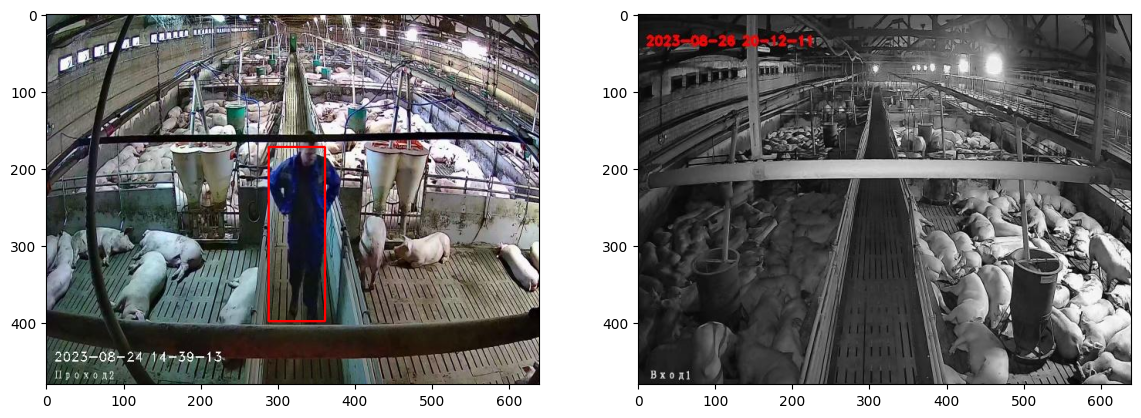

In [99]:
conf=0.15

img1 = cv2.imread("img/2023-08-24 14-39-13.jpg")
img1m = cv2.bitwise_and(img1, img1, mask = mask)
res1 = model.predict(img1m, conf=conf, classes=0)
if (len(res1[0].boxes.xyxy) > 0):
  out1 = plot_rectangle(img1, res1)
else:
  out1 = img1
out1 = cv2.cvtColor(out1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread("img/2023-08-26 20-12-11.jpg")
img2m = cv2.bitwise_and(img2, img2, mask = mask)
res2 = model.predict(img2m, conf=conf, classes=0)
if (len(res2[0].boxes.xyxy) > 0):
  out2 = plot_rectangle(img2, res2)
else:
  out2 = img2
out2 = cv2.cvtColor(out2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(out1);
ax[1].imshow(out2);
